<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/2_4_2_ExtremeValues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extreme Values & Categorical Consistency — Figures 17–23 (Chicago 2017)

This notebook produces:
- **Figure 17**: Hour of Day — Histogram (2017)
- **Figure 18**: Latitude — Histogram (2017)
- **Figure 19**: Longitude — Histogram (2017)
- **Figure 20**: Arrest — Canonicalized Distribution (2017)
- **Figure 21**: Domestic — Canonicalized Distribution (2017)
- **Figure 22**: Location Description — Top 20 Categories (2017)
- **Figure 23**: Primary Type — Top 20 Categories (2017)

Environment: **Google Colab + PySpark 3.5.1**  
Data: `/content/drive/MyDrive/Infosys 722/CrimeData_2017.csv`


In [1]:
# =============================
# 0) Setup (Colab + PySpark)
# =============================
!pip -q install pyspark==3.5.1

from google.colab import drive
drive.mount('/content/drive')  # Authorize access to your Drive

from pyspark.sql import SparkSession, functions as F, types as T
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName('ChicagoCrime2017_Figs17to23').getOrCreate()

FILE_PATH = '/content/drive/MyDrive/Infosys 722/CrimeData_2017.csv'
CSV_DIR   = '/content/drive/MyDrive/Infosys 722'

df = (spark.read
      .option('header', True)
      .option('inferSchema', True)
      .csv(FILE_PATH))

print('Columns:', df.columns[:10], '...')
print('Row count (all years):', df.count())


Mounted at /content/drive
Columns: ['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic'] ...
Row count (all years): 267562


In [2]:
# =============================
# 1) Timestamp parsing & fields
# =============================
COL_DATE = 'Date' if 'Date' in df.columns else 'ReportedDate'
COL_LAT  = 'Latitude' if 'Latitude' in df.columns else 'latitude'
COL_LON  = 'Longitude' if 'Longitude' in df.columns else 'longitude'
COL_LOC  = 'Location Description' if 'Location Description' in df.columns else ('LocationDescription' if 'LocationDescription' in df.columns else 'location_description')
COL_PT   = 'Primary Type' if 'Primary Type' in df.columns else ('PrimaryType' if 'PrimaryType' in df.columns else 'Primary_Type')

ts1 = F.to_timestamp(F.col(COL_DATE), 'MM/dd/yyyy hh:mm:ss a')
ts2 = F.to_timestamp(F.col(COL_DATE), 'MM/dd/yyyy HH:mm:ss')
df = df.withColumn('ts', F.coalesce(ts1, ts2))

def canonical_bool(colname):
    return (F.when(F.lower(F.col(colname)) == F.lit('true'), True)
             .when(F.lower(F.col(colname)) == F.lit('false'), False)
             .otherwise(F.col(colname).cast(T.BooleanType())))

if 'Arrest' in df.columns:
    df = df.withColumn('Arrest_canonical', canonical_bool('Arrest'))
if 'Domestic' in df.columns:
    df = df.withColumn('Domestic_canonical', canonical_bool('Domestic'))

df = (df
      .withColumn('Year',  F.year('ts'))
      .withColumn('Hour',  F.hour('ts'))
      .withColumn('Month', F.month('ts')))

df2017 = df.filter(F.col('Year') == 2017)
print('Row count (2017):', df2017.count())

os.makedirs('/content/figs', exist_ok=True)
plt.rcParams.update({'figure.dpi': 150})


Row count (2017): 267562


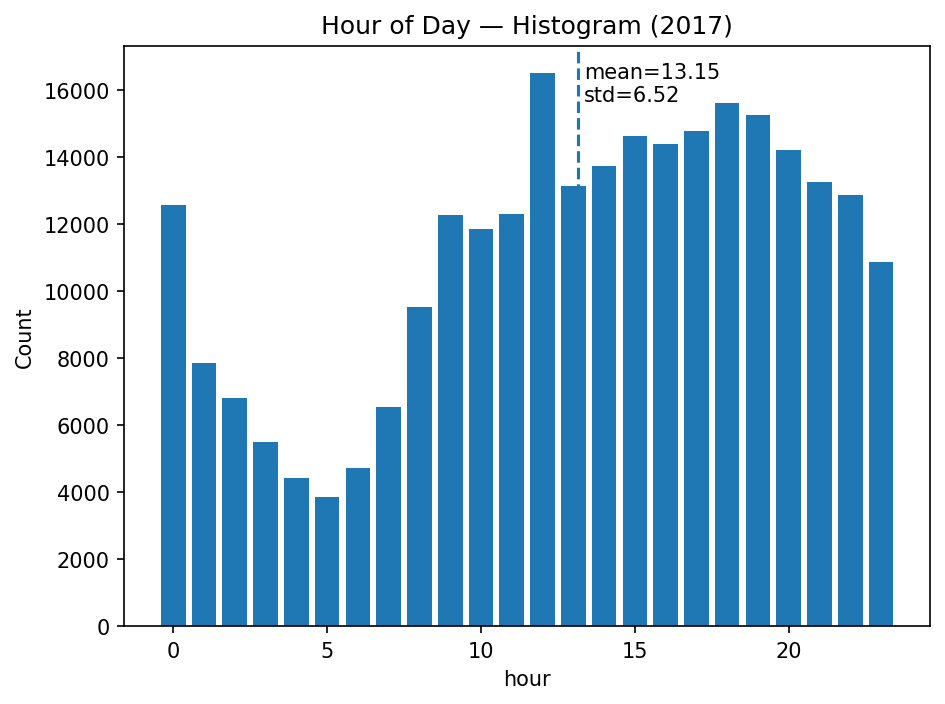

In [3]:
# =========================================
# Figure 17: Hour of Day — Histogram (2017)
# =========================================
hour_counts = (df2017.groupBy('Hour').count().orderBy('Hour')).toPandas()
stats = df2017.agg(F.mean('Hour').alias('mean'), F.stddev('Hour').alias('std')).collect()[0]
mean_hour = float(stats['mean']) if stats['mean'] is not None else float('nan')
std_hour  = float(stats['std']) if stats['std'] is not None else float('nan')

fig, ax = plt.subplots()
ax.bar(hour_counts['Hour'], hour_counts['count'])
ax.set_title('Hour of Day — Histogram (2017)')
ax.set_xlabel('hour')
ax.set_ylabel('Count')
if mean_hour == mean_hour:  # not NaN
    ax.axvline(mean_hour, linestyle='--')
    ax.text(mean_hour + 0.2, hour_counts['count'].max()*0.95,
            f'mean={mean_hour:.2f}\nstd={std_hour:.2f}')
plt.tight_layout()
plt.savefig('/content/figs/figure17_hour_hist.png')
plt.show()
hour_counts.to_csv(f"{CSV_DIR}/fig17_hour_hist.csv", index=False)


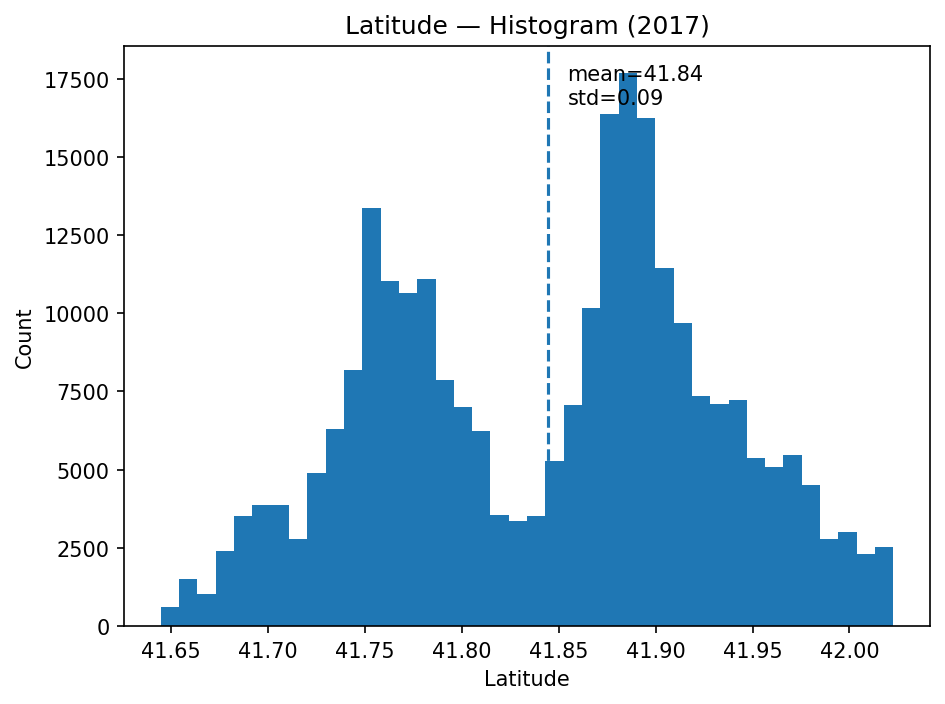

In [4]:
# ======================================
# Figure 18: Latitude — Histogram (2017)
# ======================================
lat_pd = df2017.select(F.col(COL_LAT).alias('Latitude')).dropna().toPandas()
mean_lat = float(lat_pd['Latitude'].mean()) if not lat_pd.empty else float('nan')
std_lat  = float(lat_pd['Latitude'].std())  if not lat_pd.empty else float('nan')
fig, ax = plt.subplots()
ax.hist(lat_pd['Latitude'], bins=40)
ax.set_title('Latitude — Histogram (2017)')
ax.set_xlabel('Latitude')
ax.set_ylabel('Count')
if mean_lat == mean_lat:
    ax.axvline(mean_lat, linestyle='--')
    ax.text(mean_lat + 0.01, ax.get_ylim()[1]*0.9,
            f'mean={mean_lat:.2f}\nstd={std_lat:.2f}')
plt.tight_layout()
plt.savefig('/content/figs/figure18_lat_hist.png')
plt.show()
lat_pd.to_csv(f"{CSV_DIR}/fig18_lat_values.csv", index=False)


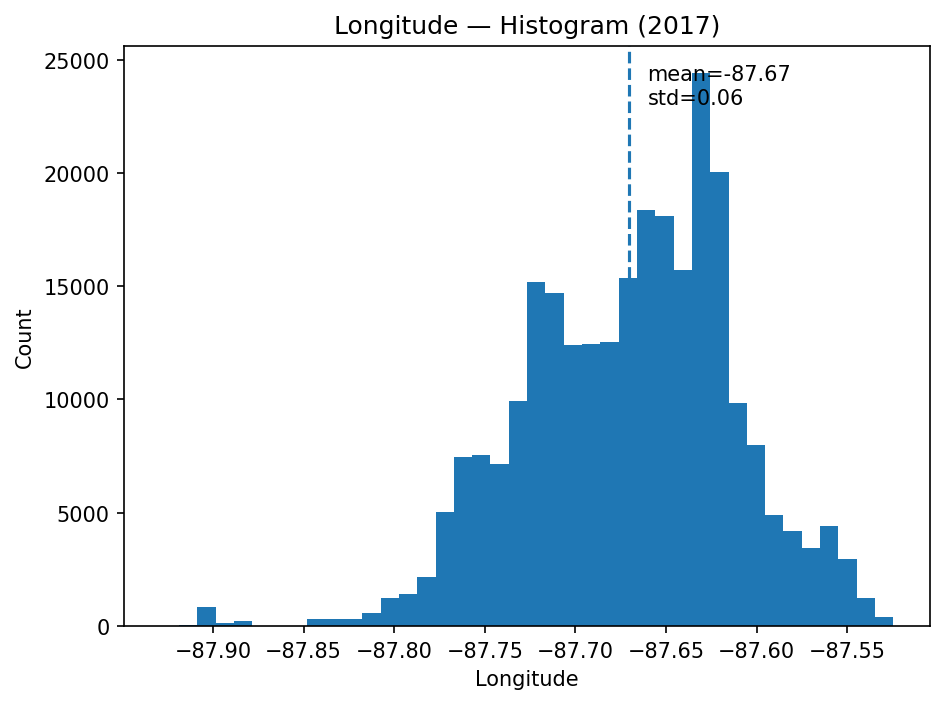

In [5]:
# =======================================
# Figure 19: Longitude — Histogram (2017)
# =======================================
lon_pd = df2017.select(F.col(COL_LON).alias('Longitude')).dropna().toPandas()
mean_lon = float(lon_pd['Longitude'].mean()) if not lon_pd.empty else float('nan')
std_lon  = float(lon_pd['Longitude'].std())  if not lon_pd.empty else float('nan')
fig, ax = plt.subplots()
ax.hist(lon_pd['Longitude'], bins=40)
ax.set_title('Longitude — Histogram (2017)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Count')
if mean_lon == mean_lon:
    ax.axvline(mean_lon, linestyle='--')
    ax.text(mean_lon + 0.01, ax.get_ylim()[1]*0.9,
            f'mean={mean_lon:.2f}\nstd={std_lon:.2f}')
plt.tight_layout()
plt.savefig('/content/figs/figure19_lon_hist.png')
plt.show()
lon_pd.to_csv(f"{CSV_DIR}/fig19_lon_values.csv", index=False)


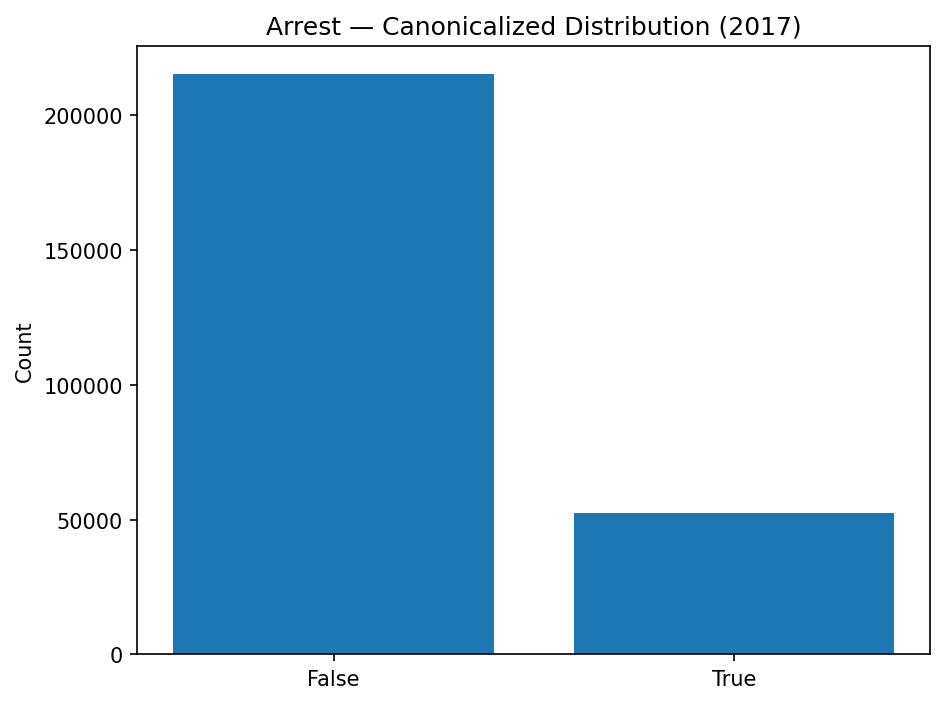

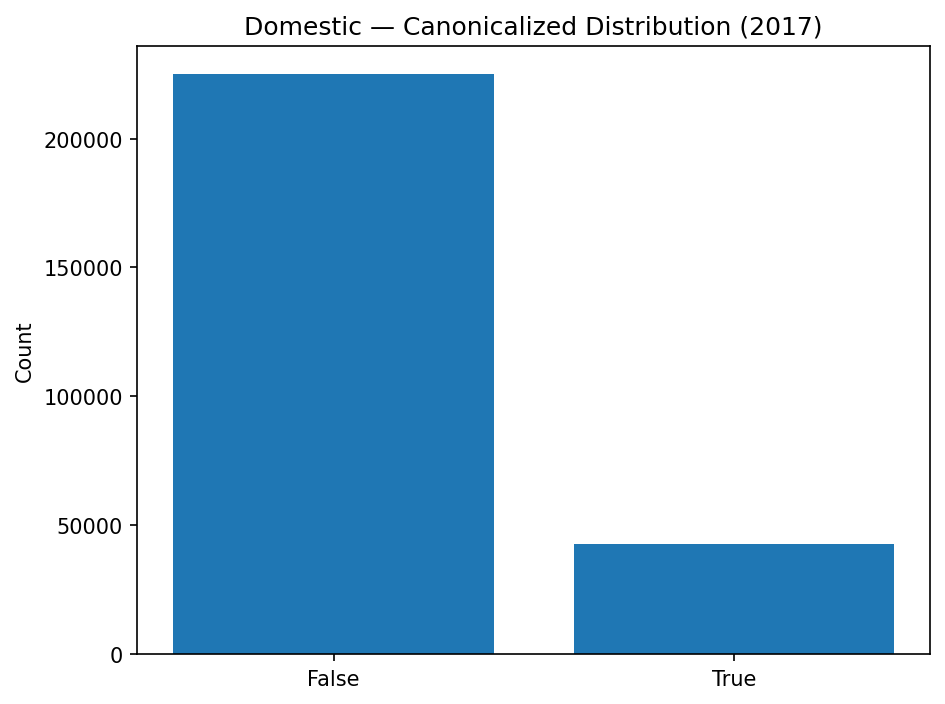

In [6]:
# =======================================================
# Figures 20 & 21: Canonicalized boolean distributions
# =======================================================
if 'Arrest_canonical' in df2017.columns:
    arrest_cnt = (df2017.groupBy('Arrest_canonical').count()
                          .orderBy(F.desc('count')).toPandas())
    fig, ax = plt.subplots()
    ax.bar(arrest_cnt['Arrest_canonical'].astype(str), arrest_cnt['count'])
    ax.set_title('Arrest — Canonicalized Distribution (2017)')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    plt.tight_layout()
    plt.savefig('/content/figs/figure20_arrest_canonical.png')
    plt.show()
    arrest_cnt.to_csv(f"{CSV_DIR}/fig20_arrest_canonical.csv", index=False)
else:
    print("Column 'Arrest' not found; skipping Figure 20.")

if 'Domestic_canonical' in df2017.columns:
    dom_cnt = (df2017.groupBy('Domestic_canonical').count()
                       .orderBy(F.desc('count')).toPandas())
    fig, ax = plt.subplots()
    ax.bar(dom_cnt['Domestic_canonical'].astype(str), dom_cnt['count'])
    ax.set_title('Domestic — Canonicalized Distribution (2017)')
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    plt.tight_layout()
    plt.savefig('/content/figs/figure21_domestic_canonical.png')
    plt.show()
    dom_cnt.to_csv(f"{CSV_DIR}/fig21_domestic_canonical.csv", index=False)
else:
    print("Column 'Domestic' not found; skipping Figure 21.")


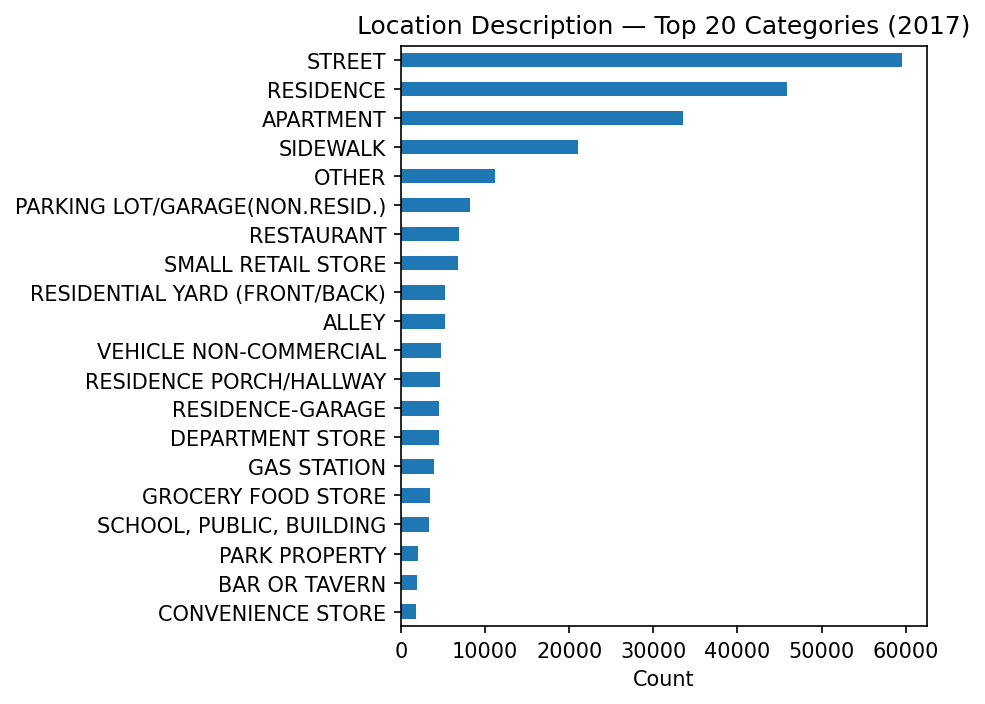

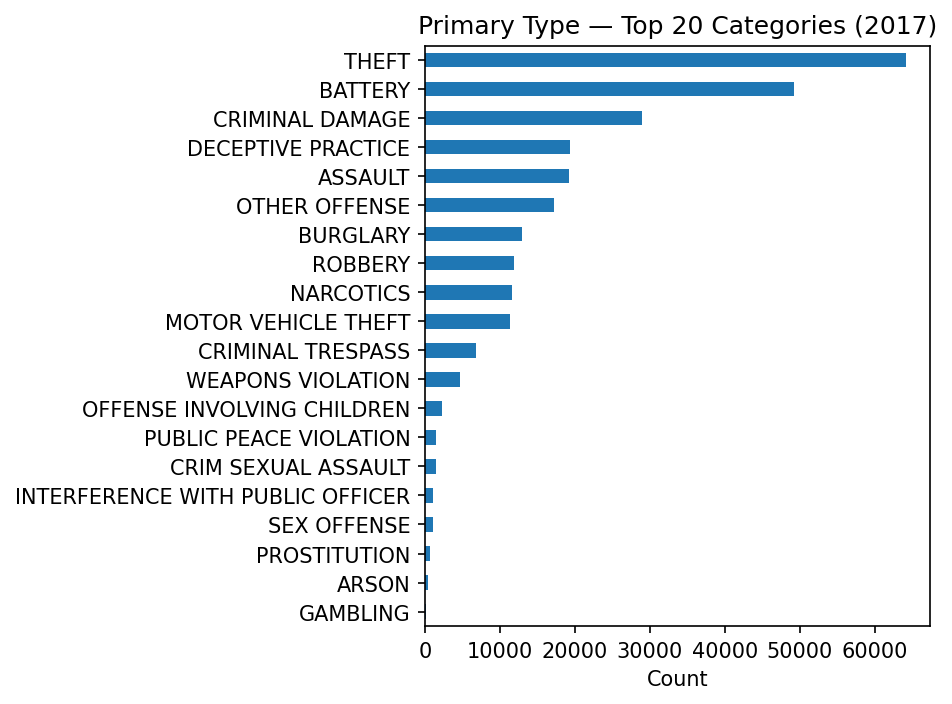

In [7]:
# ============================================================
# Figures 22 & 23: Top 20 categories (Location & Primary Type)
# ============================================================
if COL_LOC in df2017.columns:
    loc_top = (df2017.groupBy(F.col(COL_LOC).alias('Location Description'))
                      .count().orderBy(F.desc('count')).limit(20).toPandas())
    loc_top = loc_top.sort_values('count', ascending=True)
    ax = loc_top.plot(kind='barh', x='Location Description', y='count', legend=False)
    ax.set_title('Location Description — Top 20 Categories (2017)')
    ax.set_xlabel('Count')
    ax.set_ylabel('')
    plt.tight_layout()
    plt.savefig('/content/figs/figure22_location_top20.png')
    plt.show()
    loc_top.sort_values('count', ascending=False).to_csv(f"{CSV_DIR}/fig22_location_top20.csv", index=False)
else:
    print("Column 'Location Description' not found; skipping Figure 22.")

if COL_PT in df2017.columns:
    pt_top = (df2017.groupBy(F.col(COL_PT).alias('Primary Type'))
                    .count().orderBy(F.desc('count')).limit(20).toPandas())
    pt_top = pt_top.sort_values('count', ascending=True)
    ax = pt_top.plot(kind='barh', x='Primary Type', y='count', legend=False)
    ax.set_title('Primary Type — Top 20 Categories (2017)')
    ax.set_xlabel('Count')
    ax.set_ylabel('')
    plt.tight_layout()
    plt.savefig('/content/figs/figure23_primary_top20.png')
    plt.show()
    pt_top.sort_values('count', ascending=False).to_csv(f"{CSV_DIR}/fig23_primary_top20.csv", index=False)
else:
    print("Column 'Primary Type' not found; skipping Figure 23.")


In [8]:
# =============================
# 8) Output recap
# =============================
import glob, pprint
print('Figures in /content/figs:')
pprint.pp(sorted(glob.glob('/content/figs/*')))
print('\nCSVs saved to', CSV_DIR)
pprint.pp(sorted(glob.glob(CSV_DIR + '/*.csv')))


Figures in /content/figs:
['/content/figs/figure17_hour_hist.png',
 '/content/figs/figure18_lat_hist.png',
 '/content/figs/figure19_lon_hist.png',
 '/content/figs/figure20_arrest_canonical.png',
 '/content/figs/figure21_domestic_canonical.png',
 '/content/figs/figure22_location_top20.png',
 '/content/figs/figure23_primary_top20.png']

CSVs saved to /content/drive/MyDrive/Infosys 722
['/content/drive/MyDrive/Infosys 722/CrimeData_2017.csv',
 '/content/drive/MyDrive/Infosys 722/apple_stock_data.csv',
 '/content/drive/MyDrive/Infosys 722/fig17_hour_hist.csv',
 '/content/drive/MyDrive/Infosys 722/fig18_lat_values.csv',
 '/content/drive/MyDrive/Infosys 722/fig19_lon_values.csv',
 '/content/drive/MyDrive/Infosys 722/fig20_arrest_canonical.csv',
 '/content/drive/MyDrive/Infosys 722/fig21_domestic_canonical.csv',
 '/content/drive/MyDrive/Infosys 722/fig22_location_top20.csv',
 '/content/drive/MyDrive/Infosys 722/fig23_primary_top20.csv']
